In [229]:
library(SummarizedExperiment)
library(VariantAnnotation)
library(Rtsne)
library(ggplot2)
library(gplots)
library(dplyr)
library(irlba)
library(umap)
library(igraph)
library(FNN)

In [ ]:
vcf <- readRDS('~/Dropbox/mixed/original/Map_K10_VBC_CLI.whitelist.noindel.rds')
meta <- read.csv('~/Dropbox/mixed/meta/MetaDATAJohnes2.csv', header = TRUE)
rownames(meta) <- meta$SeqID
meta <- meta[colnames(vcf), ]

In [126]:
head(meta)
table(meta$Type2)
meta %>% filter(CowID == 241)

,SeqID,SampleID,CowID,State,Farm,Type,Mix,Date,uniID,Type2,Type2_num,Contamination
MAP129,MAP129,129,1283,NY,9,tissue,1,2006,NY_1283,Ileum_20cm_from_IC_Valve,4,0
MAP381,MAP381,381,9999,VT,11,environmental,0,2004,VT_9999,environmental,100,0
MAP350,MAP350,350,228,PA,10,tissue,0,2008,PA_228,LymphNode2,6,0
MAP022,MAP022,22,1085,NY,9,fecal,0,2004,NY_1085,fecal,1,0
MAP514,MAP514,514,506,VT,11,fecal,0,2007,VT_506,fecal,1,0
MAP545,MAP545,545,120,VT,11,tissue,0,2007,VT_120,Ileum_20cm_from_IC_Valve,4,0



           environmental                    fecal          fecal_slaughter 
                      91                      243                       19 
Ileum_20cm_from_IC_Valve           Ileum_IC_Valve               LymphNode1 
                      41                       37                       49 
              LymphNode2     MesentericLymphNode1     MesentericLymphNode2 
                      43                        1                        1 

SeqID,SampleID,CowID,State,Farm,Type,Mix,Date,uniID,Type2,Type2_num,Contamination
MAP533,533,241,VT,11,fecal,0,2007,VT_241,fecal,1,0
MAP619,619,241,VT,11,tissue,0,2008,VT_241,Ileum_IC_Valve,3,0
MAP566,566,241,VT,11,fecal,0,2008,VT_241,fecal,1,0
MAP620,620,241,VT,11,fecal,0,2008,VT_241,fecal_slaughter,2,0
MAP617,617,241,VT,11,tissue,0,2008,VT_241,LymphNode2,6,0
MAP616,616,241,VT,11,tissue,0,2008,VT_241,LymphNode1,5,0
MAP556,556,241,VT,11,fecal,0,2008,VT_241,fecal,1,0
MAP618,618,241,VT,11,tissue,0,2008,VT_241,Ileum_20cm_from_IC_Valve,4,0


In [127]:
vcf

class: CollapsedVCF 
dim: 2755 525 
rowRanges(vcf):
  GRanges with 5 metadata columns: paramRangeID, REF, ALT, QUAL, FILTER
info(vcf):
  DataFrame with 43 columns: NS, DP, DPB, AC, AN, AF, RO, AO, PRO, PAO, QR, ...
info(header(vcf)):
           Number Type    Description                                          
   NS      1      Integer Number of samples with data                          
   DP      1      Integer Total read depth at the locus                        
   DPB     1      Float   Total read depth per bp at the locus; bases in rea...
   AC      A      Integer Total number of alternate alleles in called genotypes
   AN      1      Integer Total number of alleles in called genotypes          
   AF      A      Float   Estimated allele frequency in the range (0,1]        
   RO      1      Integer Count of full observations of the reference haplot...
   AO      A      Integer Count of full observations of this alternate haplo...
   PRO     1      Float   Reference allele obs

In [128]:
is_NY <- meta$State == 'NY'
vcf <- vcf[, is_NY]
meta <- meta[is_NY, ]

In [129]:
GT <- geno(vcf)$GT

In [130]:
table(c(GT))
GT[GT %in% c('.')] <- '0/0' # missing values
GT[GT%in% c('0/2', '0/3')] <- '0/1'
table(c(GT))


     .    0/0    0/1    0/2    0/3    1/1 
    40 489530   1608     55      6   1906 


   0/0    0/1    1/1 
489570   1669   1906 

In [131]:
AO <- geno(vcf)$AO # alt read count
DP <- geno(vcf)$DP

In [132]:
is_dp_na <- is.na(DP)
DP[is_dp_na] <- 0
AO[is_dp_na] <- 0
ao_len <- sapply(AO, length)
mult <- which(ao_len > 1)
AO[mult] <- sapply(AO[mult], max)
AO <- matrix(unlist(AO), nrow = nrow(DP), ncol = ncol(DP))

In [133]:
X <- AO / DP # alternative allele ratio
X[is.na(X)] <- 0

In [12]:
for (cow_id in c(114, 241)){
    cat(sprintf('Cow: %d\n', cow_id))
    cow <- meta$CowID == cow_id
    GT_freq_cow <- do.call('rbind', lapply(
        1:nrow(GT), 
        function(i) GT[i, cow] %>% factor(c('0/0', '0/1', '1/1'), labels = c('AA', 'AB', 'BB')) %>% table()
    )) %>% 
    as.data.frame() %>% 
    filter(AA < sum(cow)) %>%
    print()
}

Cow: 114
   AA AB BB
1   0  0  8
2   0  0  8
3   0  0  8
4   0  0  8
5   0  0  8
6   7  1  0
7   7  1  0
8   6  2  0
9   0  0  8
10  7  1  0
11  0  8  0
12  6  2  0
13  7  1  0
14  6  2  0
15  7  1  0
16  0  0  8
17  7  1  0
18  0  0  8
19  0  0  8
20  7  1  0
21  7  1  0
22  0  0  8
23  5  3  0
24  7  1  0
25  0  0  8
Cow: 241
   AA AB BB
1   0  0  8
2   7  1  0
3   0  0  8
4   7  1  0
5   7  1  0
6   0  0  8
7   0  0  8
8   6  2  0
9   6  2  0
10  7  1  0
11  7  1  0
12  7  1  0
13  7  1  0
14  7  1  0
15  7  1  0
16  0  0  8
17  7  1  0
18  7  1  0
19  7  1  0
20  6  2  0
21  7  1  0
22  7  1  0
23  7  1  0
24  7  1  0
25  0  0  8
26  4  4  0
27  7  1  0
28  7  1  0
29  7  1  0
30  5  3  0
31  7  1  0
32  7  1  0
33  7  1  0
34  7  1  0
35  7  1  0
36  7  1  0
37  6  2  0
38  7  1  0
39  7  1  0
40  7  1  0
41  7  1  0
42  7  1  0
43  7  1  0
44  7  1  0
45  7  1  0
46  7  1  0
47  7  1  0
48  4  4  0
49  7  1  0
50  7  1  0
51  7  1  0
52  7  1  0
53  5  3  0
54  7  1  0
55  7  1  

In [136]:
# We define the orphan snps as the ones that are present in only one sample as
# heterozygous or homozygous SNP
GT_freq <- do.call('rbind', lapply(
    1:nrow(GT), 
    function(i) GT[i, ] %>% factor(c('0/0', '0/1', '1/1'), labels = c('AA', 'AB', 'BB')) %>% table()
)) %>% 
    as.data.frame() %>%
    mutate(snp_id = rownames(GT)) %>%
    filter(!(AB == 1 & BB == 0)) %>%
    filter(!(AB == 0 & BB == 1)) %>%
    filter(!(AA == 0 & AB == 0)) %>% 
    filter(!(AB == 0 & BB == 0)) %>%
    arrange(AB) %>% 
    print()



     AA  AB  BB                      snp_id
1   177   0   2   Map_K10_VBC_CLI:49215_A/G
2   177   0   2   Map_K10_VBC_CLI:53592_C/T
3   174   0   5   Map_K10_VBC_CLI:56276_T/C
4   176   0   3  Map_K10_VBC_CLI:143639_T/C
5   172   0   7  Map_K10_VBC_CLI:145647_C/T
6   177   0   2  Map_K10_VBC_CLI:175227_A/G
7   174   0   5  Map_K10_VBC_CLI:186552_G/A
8   172   0   7 Map_K10_VBC_CLI:4022146_G/A
9   177   0   2 Map_K10_VBC_CLI:4088840_G/A
10  174   0   5 Map_K10_VBC_CLI:4128408_G/A
11  177   0   2 Map_K10_VBC_CLI:4155202_T/G
12  177   1   1    Map_K10_VBC_CLI:3367_C/T
13  173   1   5   Map_K10_VBC_CLI:51678_A/G
14  173   1   5   Map_K10_VBC_CLI:60165_C/T
15  165   1  13   Map_K10_VBC_CLI:77507_C/A
16  173   1   5  Map_K10_VBC_CLI:137792_C/T
17  165   1  13  Map_K10_VBC_CLI:165969_C/T
18  177   1   1  Map_K10_VBC_CLI:183128_G/T
19  177   1   1 Map_K10_VBC_CLI:2025382_C/T
20  173   1   5 Map_K10_VBC_CLI:2072948_C/T
21  173   1   5 Map_K10_VBC_CLI:2075511_G/A
22  173   1   5 Map_K10_VBC_CLI:

In [159]:
set.seed(1)
X_no_orphan <- X[GT_freq$snp_id, ]
u <- irlba(X_no_orphan, nu = 1, nv = 5)$v
y_tsne <- Rtsne(u, check_duplicates = FALSE)$Y

In [173]:
d <- data.frame(
    x = y_tsne[, 1], 
    y = y_tsne[, 2],
    n_heterozygous = (X_no_orphan > 0.1 & X_no_orphan < 0.9) %>% colSums(),
    cow_id = meta$CowID,
    type_1 = meta$Type %>% factor(),
    type_2 = meta$Type2 %>% factor(),
    farm = meta$Farm %>% factor(),
    contamination = meta$Contamination %>% factor(),
    date = meta$Date %>% factor(),
    state = meta$State %>% factor(),
    mix = meta$Mix %>% factor()
)
head(d)

,x,y,n_heterozygous,cow_id,type_1,type_2,farm,contamination,date,state,mix
MAP129,3.668753,-3.303833,29,1283,tissue,Ileum_20cm_from_IC_Valve,9,0,2006,NY,1
MAP022,2.441327,-1.987906,8,1085,fecal,fecal,9,0,2004,NY,0
MAP153,2.240757,3.020176,6,1181,tissue,LymphNode1,9,0,2006,NY,1
MAP160,-3.466697,-3.564802,2,1355,tissue,Ileum_20cm_from_IC_Valve,9,0,2006,NY,0
MAP168,3.756924,8.876470,3,1645,fecal,fecal,9,0,2006,NY,0
MAP140,-4.535493,-4.579195,12,2158,tissue,LymphNode2,9,0,2006,NY,1


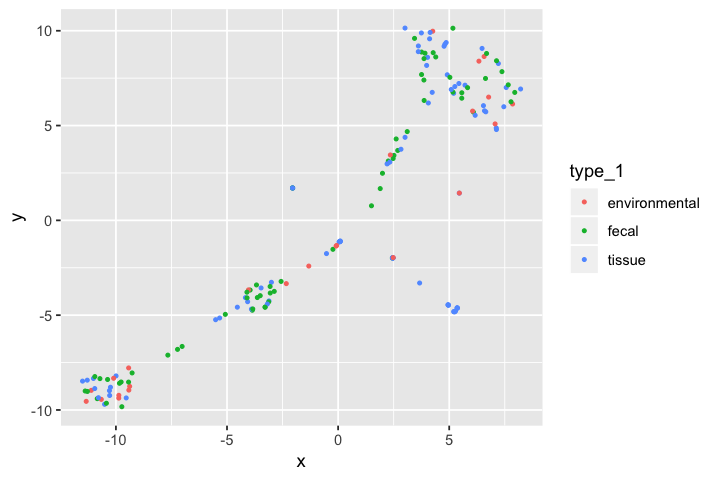

In [161]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = type_1)) + 
    geom_point(size = 0.75) 

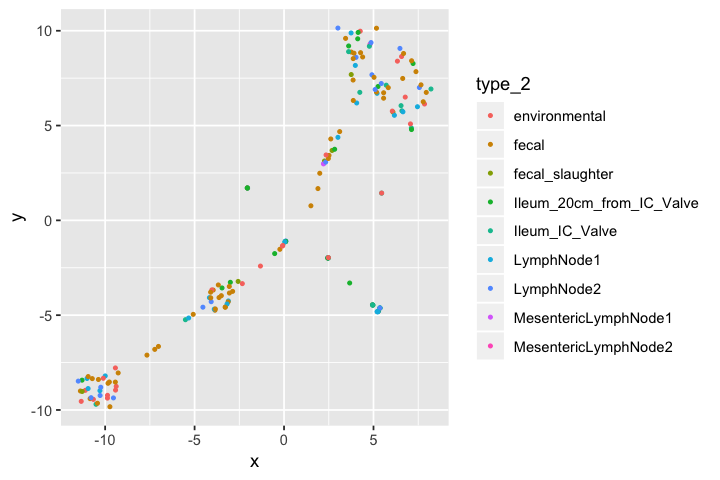

In [162]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = type_2)) + 
    geom_point(size = 0.75) 

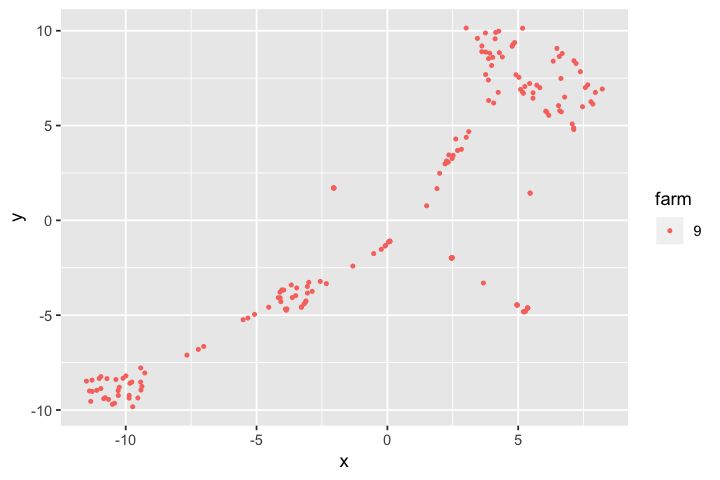

In [163]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = farm)) + 
    geom_point(size = 0.75) 

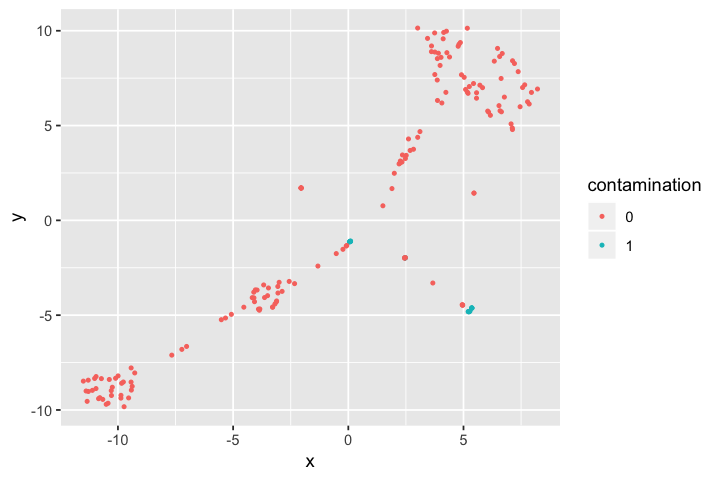

In [164]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = contamination)) + 
    geom_point(size = 0.75) 

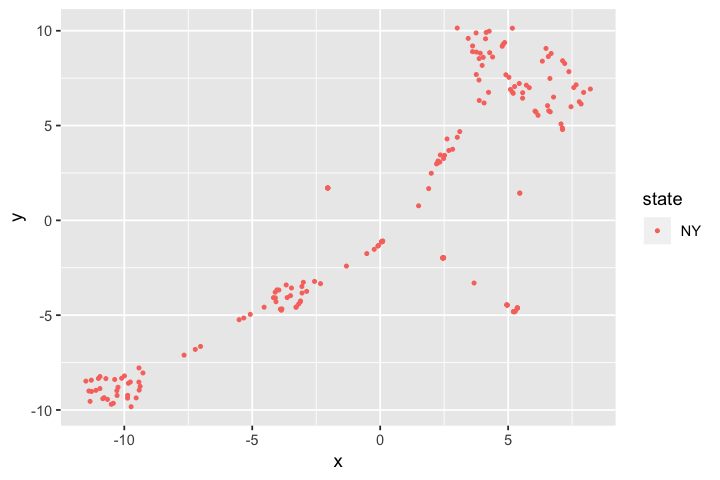

In [165]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = state)) + 
    geom_point(size = 0.75) 

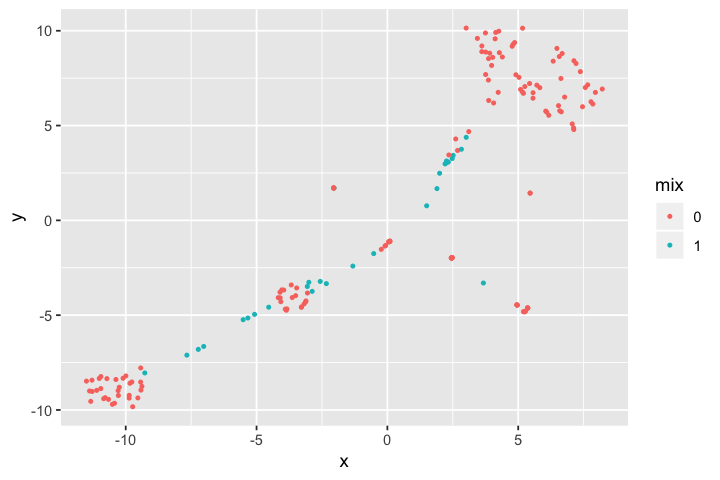

In [166]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = mix)) + 
    geom_point(size = 0.75) 

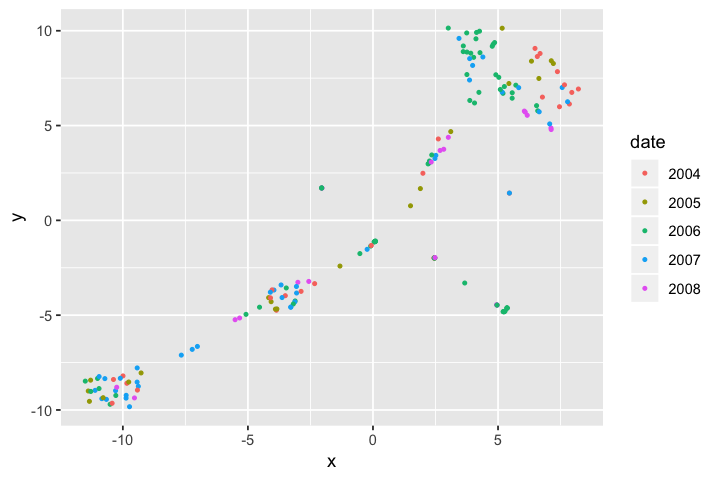

In [172]:
options(repr.plot.width=6, repr.plot.height=4)
d %>%
    ggplot(aes(x = x, y = y, color = date)) + 
    geom_point(size = 0.75) 

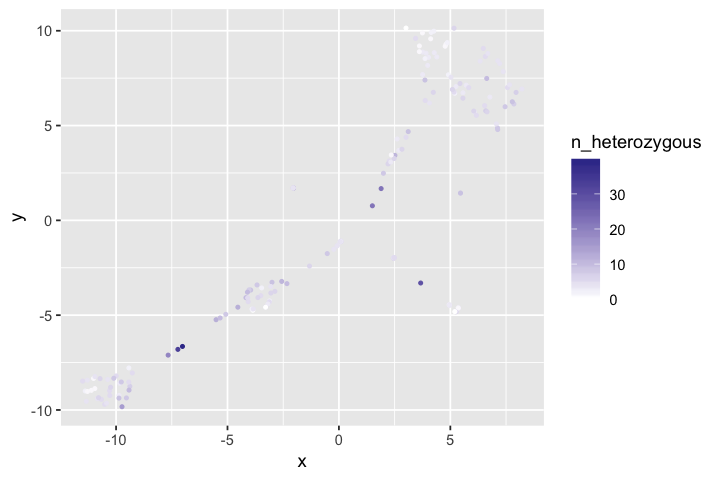

In [174]:
options(repr.plot.width=6, repr.plot.height=4)
d %>% 
    ggplot(aes(x = x, y = y, color = n_heterozygous)) + 
    geom_point(size = 0.75) +
    scale_colour_gradient2()

In [188]:
k <- 10
knn <- get.knn(y_tsne, k)

In [197]:
g <- sparseMatrix(
    i = rep(1:nrow(y_tsne), k), 
    j = c(knn[[1]]), 
    x = c(1 / (1 + knn[[2]])),
    dims = c(nrow(y_tsne), nrow(y_tsne))
)
g <- (g + t(g)) / 2

In [198]:
g <- graph.adjacency(g, mode = 'undirected', weighted = TRUE)

In [227]:
g_mst <- mst(g)
V(g_mst)$color <- 'black'
V(g_mst)$color[d$date == '2004'] <- 'red'
V(g_mst)$color[d$date == '2005'] <- 'green'
V(g_mst)$name <- ''

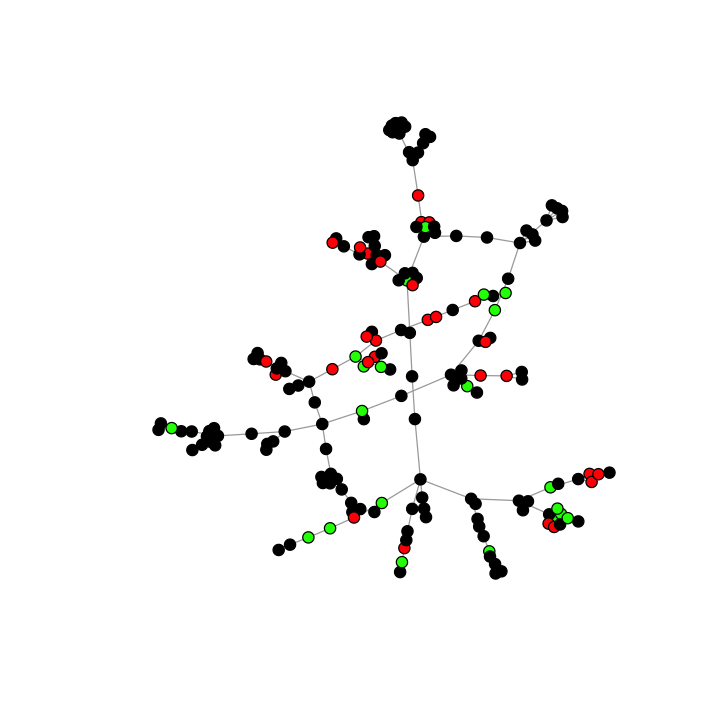

In [228]:
options(repr.plot.width=6, repr.plot.height=6)
plot(g_mst, vertex.size = 5) #, layout = layout_as_tree)